In [22]:
%load_ext autoreload
%autoreload 2

from SO3n import so3_diffuser, SO3Algebra
from R3n import r3_diffuser
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import math
import math
import random
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geoopt
from geoopt.optim import (RiemannianAdam)
Stiefel = geoopt.Stiefel()
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.cm as cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


THIS CODE IS BASED ON THE FOLLOWING TWO PAPERS: 
DENOISING DIFFUSION PROBABILISTIC MODELS ON SO(3) FOR ROTATIONAL ALIGNMENT by LEACH et al
SE(3) diffusion model with application to protein backbone generation by Yim et al 

Operations on SO(3) have been taken from: https://github.com/qazwsxal/diffusion-extensions

In [23]:
import numpy as np
import torch
from scipy.spatial.transform import Rotation as SciRot

so3 = SO3Algebra()



In [24]:
import torch, torch.nn as nn
from typing import Literal
class ResidualSE3Head(nn.Module):
    def __init__(self, feat_dim: int, d_model: int = 256,
                 hidden_dim: int = 256, n_blocks: int = 3,
                 dropout: float = 0.1):
        super().__init__()

        self.input_proj = nn.Linear(feat_dim, hidden_dim)

        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=4,
                dim_feedforward=4 * hidden_dim,
                dropout=dropout,
                batch_first=True
            ) for _ in range(n_blocks)
        ])

        self.out_rot   = nn.Linear(hidden_dim, 3)
        self.out_trans = nn.Linear(hidden_dim, 3)

    def forward(self, feats: torch.Tensor) -> torch.Tensor:
        # feats: [B, N, feat_dim]
        x = self.input_proj(feats)  # [B, N, hidden_dim]
        for blk in self.blocks:
            x = blk(x)  # full cross-token (N-wise) attention within each B
        return torch.cat([self.out_rot(x), self.out_trans(x)], dim=-1)  # [B, N, 6]


class SE3MLP(nn.Module):
    def __init__(self, d_model=256, hidden_dim=256, n_blocks=3, dropout=0.1):
        super().__init__()
        self.FEAT_DIM = 13

        self.time_embed = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU()
        )

        self.flag_embed = nn.Embedding(2, d_model)

        self.residual_head = ResidualSE3Head(
            feat_dim=self.FEAT_DIM + d_model,
            d_model=d_model,
            hidden_dim=hidden_dim,
            n_blocks=n_blocks,
            dropout=dropout
        )

    def _time_flag_emb(self, t: torch.Tensor, c: torch.Tensor, N: int) -> torch.Tensor:
        """
        Inputs: t, c — shape (B,) or scalar
        Returns: [B, N, d_model]
        """
        B = t.size(0)
        t_e = self.time_embed(t.view(B, 1).float())     # [B, d_model]
        c_e = self.flag_embed(c.view(B).long())         # [B, d_model]
        emb = t_e + c_e                                 # [B, d_model]
        return emb.unsqueeze(1).expand(B, N, -1)        # [B, N, d_model]

    def forward(self, R_t: torch.Tensor, T_t: torch.Tensor,
                t: torch.Tensor, c: torch.Tensor):
        """
        Inputs:
            R_t: [B, N, 3, 3]
            T_t: [B, N, 3]
            t:   [B] or scalar
            c:   [B] or scalar
        Output:
            [B, N, 6]
        """
        B, N = R_t.shape[:2]
        device = R_t.device

        if isinstance(t, (int, float)):
            t = torch.full((B,), float(t), device=device)
        if isinstance(c, (int, float)):
            c = torch.full((B,), int(c), device=device)

        # Flatten rotations and build feature vector
        flat_R = R_t.view(B, N, 9)                     # [B, N, 9]
        feats  = torch.cat([flat_R, T_t, c.view(B, 1, 1).expand(B, N, 1)], dim=-1)  # [B, N, 13]

        # Time + flag embeddings
        emb = self._time_flag_emb(t, c, N)             # [B, N, d_model]
        input_tokens = torch.cat([feats, emb], dim=-1) # [B, N, 13 + d_model]

        return self.residual_head(input_tokens)        # [B, N, 6]

In [86]:
class se3n_diffuser:
    def __init__(self, T, score = False, batch_size=64, device="cpu", betas=None, model_path = None):
        self.device      = torch.device(device)
        self.batch_size  = batch_size

        self.so3 = so3_diffuser(T, batch_size, betas, device=device)
        self.r3  = r3_diffuser(T, batch_size, betas, device=device)
        self.score = score
        
        self.model = SE3MLP(    
            d_model=256,          
            hidden_dim=256,      
            n_blocks=3,         
            dropout=0.1         
        ).to(self.device)
        if(model_path is not None): 
            self.model.load_state_dict(torch.load("se3_model_weights.pth"))
            self.model.eval()
        self.opt   = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        self.T = T    

    def batch_se3(self, R_clean, T_clean, conditioning, epoch=None, gamma=5):
        """
        R_clean : (B, N, 3, 3)
        T_clean : (B, N, 3)
        conditioning : (B,) or scalar flag
        """
        self.model.train()
        B, N = R_clean.shape[:2]

        # Sample scalar timestep t
        t = torch.randint(1, self.T, (1,), device=self.device).item()

        # Generate SO(3) noise for all B*N
        R_noise, v_noise = self.so3.generate_noise(t, B, N)       # [B, N, 3, 3], [B, N, 3]
        T_noise = self.r3.generate_noise(t, B, N)                  # [B, N, 3]

        # Compute target noise vectors
        sigma_t = torch.sqrt(1 - self.so3.alpha_bars[t])
        v_target = v_noise / sigma_t                               # [B, N, 3]
        trans_noise_target = T_noise / torch.sqrt(1 - self.r3.alpha_bars[t])

        # Apply noise
        R_t = self.so3.add_noise(R_clean, R_noise, t)             # [B, N, 3, 3]
        T_t = self.r3.add_noise(T_clean, T_noise, t)              # [B, N, 3]

        # Time and conditioning setup
        if isinstance(conditioning, (int, float)):
            conditioning = torch.full((B,), int(conditioning), device=self.device)

        t_tensor = torch.full((B,), float(t), device=self.device)

        # Predict noise using model
        pred = self.model(R_t, T_t, t_tensor, conditioning)        # [B, N, 6]
        pred_rot, pred_trans = pred[..., :3], pred[..., 3:]        # both [B, N, 3]

        # Loss
        if not self.score:
            loss = 0.5 * ((pred_rot - v_target) ** 2).mean() + \
                0.5 * ((pred_trans - trans_noise_target) ** 2).mean()
        else:
            loss = self.so3.compare_score(pred_rot)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()


    @torch.no_grad()
    def sample(self, conditioning, stop=1, B=1, N=1, guidance=False, optim_steps=1, cost=None):
        """
        Sample B SE(3)^N structures.

        Args:
            conditioning: (B,) or scalar flag
            stop: starting timestep (usually 1)
            B: batch size
            N: number of SE(3) elements per structure
        Returns:
            R_t: [B, N, 3, 3]
            T_t: [B, N, 3]
        """
        # Initialize rotations and translations
        R_t = torch.stack([
            torch.stack([torch.from_numpy(Rot.random().as_matrix()).float()
                        for _ in range(N)])
            for _ in range(B)
        ]).to(self.device)  # [B, N, 3, 3]

        T_t = torch.randn((B, N, 3), device=self.device)  # [B, N, 3]

        # Conditioning flag
        if isinstance(conditioning, (int, float)):
            conditioning = torch.full((B,), int(conditioning), device=self.device)

        for t in reversed(range(stop, self.T)):
            t_tensor = torch.full((B,), float(t), device=self.device)

            # Predict noise
            eps = self.model(R_t, T_t, t_tensor, conditioning)  # [B, N, 6]
            eps_rot, eps_trans = eps[..., :3], eps[..., 3:]     # [B, N, 3], [B, N, 3]

            # Reverse steps
            R_t = self.so3._se_sample_batch(R_t, t, eps_rot, guidance, optim_steps, cost)[0]  # [B, N, 3, 3]
            T_t = self.r3._eu_sample_n(T_t, t, eps_trans, guidance, optim_steps, cost)[0]    # [B, N, 3]

        return R_t.squeeze(0), T_t.squeeze(0)  # [N, 3, 3], [N, 3]
    

In [101]:
import torch 

def build_mock_dataset_se3n(device, N=2):
    """
    Returns a list of (R_clean, T_clean, flag) tuples.
    Each R_clean: [N, 3, 3]
    Each T_clean: [N, 3]
    """
    angle = np.pi / 4  # 45 degrees
    rot_axis_list = [
        np.array([1.0, 0.0, 0.0]),   # x-axis
        np.array([0.0, 0.0, 1.0])    # z-axis
    ]
    # Provide a distinct translation for each of the 2x2 = 4 total rotations
    trans_vectors = [
        np.array([1.0, 1.0, 1.0]),
        np.array([1.5, 0.0, -1.0]),
        np.array([-2.0, 0.0, 1.0]),
        np.array([0.0, -1.0, -2.0])
    ]

    dataset = []

    for i, axis in enumerate(rot_axis_list):
        rotvec_pos = torch.tensor(axis * angle, dtype=torch.float32, device=device)
        rotvec_neg = torch.tensor(-axis * angle, dtype=torch.float32, device=device)

        R1 = torch.tensor(Rot.from_rotvec(rotvec_pos.cpu().numpy()).as_matrix(), dtype=torch.float32, device=device)
        R2 = torch.tensor(Rot.from_rotvec(rotvec_neg.cpu().numpy()).as_matrix(), dtype=torch.float32, device=device)
        R_pair = torch.stack([R1, R2], dim=0)  # [2, 3, 3]

        T_pair = torch.tensor(np.stack([
            trans_vectors[2 * i],
            trans_vectors[2 * i + 1]
        ]), dtype=torch.float32, device=device)  # [2, 3]

        c = torch.tensor(i, dtype=torch.long, device=device)

        dataset.append((R_pair, T_pair, c))

    return dataset


def train_synthetic_pairs(
        diffuser,
        dataset,             # list/array of (R, T, c) triples
        epochs: int = 100,
        log_every: int = 10_000):

    B      = diffuser.batch_size
    device = diffuser.device
    K      = len(dataset)

    losses = []

    for ep in range(1, epochs + 1):
        # ---- sample a mini-batch of indices ----
        idx = torch.randint(high=K, size=(B,))

        Rs, Ts, Cs = [], [], []
        for i in idx.tolist():
            R_i, T_i, c_i = dataset[i]         # (3,3), (3,), flag {0|1}
            Rs.append(R_i)
            Ts.append(T_i)
            Cs.append(c_i)

        Rs = torch.stack(Rs).to(device)        # (B,3,3)
        Ts = torch.stack(Ts).to(device)        # (B,3)
        Cs = torch.stack(Cs).to(device)        # (B,)  conditioning flags

        # ---- one optimizer step ----
        loss = diffuser.batch_se3(Rs, Ts, Cs, epoch=ep)

        if loss <= 10:                         # sanity filter
            losses.append(loss)

        if ep % log_every == 0:
            print(f"[pair SE(3)] epoch {ep:5d} | loss {loss:.6f}")

    return losses

[pair SE(3)] epoch 10000 | loss 0.209258
[pair SE(3)] epoch 20000 | loss 0.038782
[pair SE(3)] epoch 30000 | loss 0.030756
[pair SE(3)] epoch 40000 | loss 0.044551


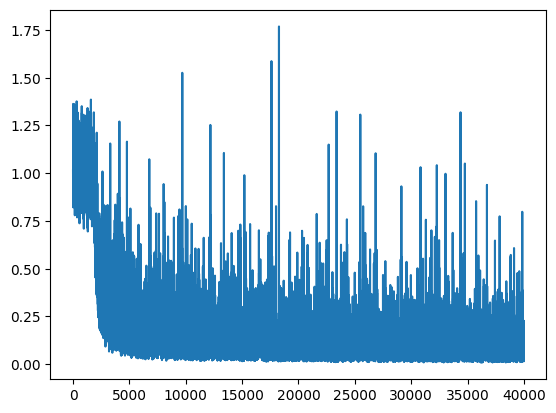

In [102]:
diffuser = se3n_diffuser(T=100, batch_size=16, device="cpu")
dataset = build_mock_dataset_se3n(device=diffuser.device, N=2)
losses = train_synthetic_pairs(diffuser, dataset, epochs = 40000)

plt.plot(losses)

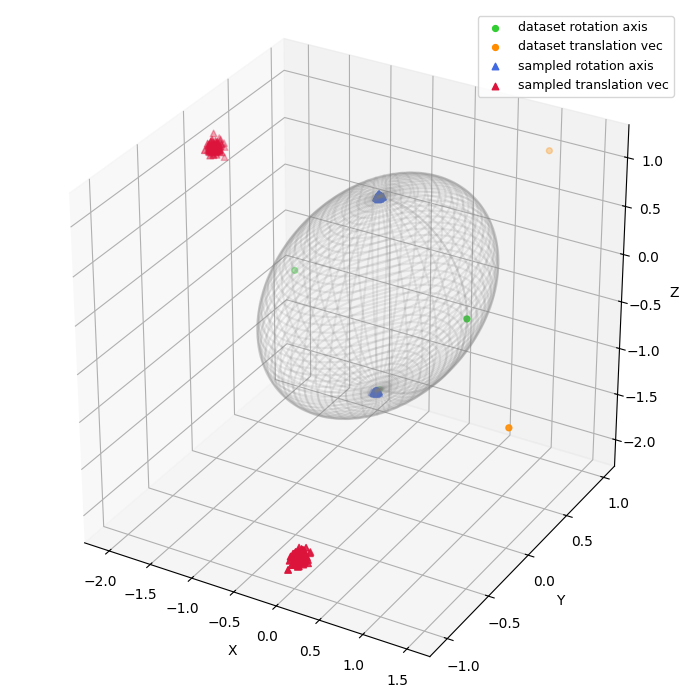

(array([[-1.83572645e-02, -4.62848857e-03,  9.99820778e-01],
        [-2.07750929e-02, -1.81547984e-02, -9.99619327e-01],
        [ 1.37314411e-02, -5.06250496e-02, -9.98623328e-01],
        [-1.49791576e-03, -1.29099728e-02,  9.99915541e-01],
        [ 3.04676181e-03, -3.27263507e-02, -9.99459706e-01],
        [-4.01740322e-03, -2.27622066e-02,  9.99732836e-01],
        [-1.97257817e-03, -3.58411105e-02, -9.99355554e-01],
        [-2.60518945e-02,  4.15061731e-03,  9.99651975e-01],
        [-4.46788358e-03, -1.51300446e-02, -9.99875552e-01],
        [-2.55144194e-02,  6.70956818e-03,  9.99651937e-01],
        [-3.33195198e-03, -1.56543248e-02,  9.99871912e-01],
        [-2.29043054e-02, -4.55106214e-02, -9.98701245e-01],
        [-1.44035096e-02, -4.81308520e-02, -9.98737183e-01],
        [-1.26233953e-02, -1.08478699e-02,  9.99861477e-01],
        [-2.82908349e-02, -4.56018012e-02, -9.98559014e-01],
        [-1.47834376e-02, -4.71513600e-03,  9.99879601e-01],
        [-7.51378370e-03

In [106]:
plot_samples(diffuser, dataset, B = 100)

In [105]:
def plot_samples(diffuser, dataset, B=10, N=2, stop=1, guidance=False, optim_steps=1, cost=None):
    """
    Generate and plot SE(3)^N samples and compare with dataset poses.

    Args:
        diffuser: the trained model
        dataset: list of (R_clean [N,3,3], T_clean [N,3], flag) tuples
        B: number of samples (i.e., batch size)
        N: number of SE(3) elements per sample
    """
    device = diffuser.device

    # ------------------------------------------------------------
    # 1. Generate sampled SE(3)^N batches
    rot_axes_samp, trans_axes_samp = [], []
    for _ in range(B):
        c = torch.randint(0, 2, (1,), dtype=torch.long, device=device)
        c = torch.tensor([1], dtype=torch.long, device=device)
        R_s, T_s = diffuser.sample(c, stop=stop, N=N,
                                   guidance=guidance, optim_steps=optim_steps, cost=cost)
        # R_s: [N, 3, 3], T_s: [N, 3]

        for i in range(N):
            omega = Rot.from_matrix(R_s[i].cpu().numpy()).as_rotvec()
            theta = np.linalg.norm(omega)
            axis = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
            rot_axes_samp.append(axis)
            trans_axes_samp.append(T_s[i].cpu().numpy())

    rot_axes_samp = np.stack(rot_axes_samp)    # [B*N, 3]
    trans_axes_samp = np.stack(trans_axes_samp)

    # ------------------------------------------------------------
    # 2. Process dataset rotations and translations
    rot_axes_ds, trans_axes_ds = [], []
    for R_i, T_i, _ in dataset:
        R_i = R_i.cpu().numpy()  # shape [N, 3, 3]
        T_i = T_i.cpu().numpy()  # shape [N, 3]

        for j in range(R_i.shape[0]):
            omega = Rot.from_matrix(R_i[j]).as_rotvec()
            theta = np.linalg.norm(omega)
            axis = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
            rot_axes_ds.append(axis)
            trans_axes_ds.append(T_i[j])

    rot_axes_ds = np.stack(rot_axes_ds)      # [D*N, 3]
    trans_axes_ds = np.stack(trans_axes_ds)

    # ------------------------------------------------------------
    # 3. Plot
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(111, projection='3d')

    # dataset = green/orange
    ax.scatter(rot_axes_ds[:, 0], rot_axes_ds[:, 1], rot_axes_ds[:, 2],
               c='limegreen', s=18, label='dataset rotation axis')
    ax.scatter(trans_axes_ds[:, 0], trans_axes_ds[:, 1], trans_axes_ds[:, 2],
               c='darkorange', s=18, label='dataset translation vec')

    # samples = blue/red
    ax.scatter(rot_axes_samp[:, 0], rot_axes_samp[:, 1], rot_axes_samp[:, 2],
               c='royalblue', s=22, label='sampled rotation axis', marker='^')
    ax.scatter(trans_axes_samp[:, 0], trans_axes_samp[:, 1], trans_axes_samp[:, 2],
               c='crimson', s=22, label='sampled translation vec', marker='^')

    # unit sphere wireframe for context
    u, v = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.15)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend(loc="upper right", fontsize=9)
    plt.tight_layout()
    plt.show()

    return rot_axes_samp, trans_axes_samp

def plot_samples_correlation(diffuser, num_samples=100, guidance=False, optim_steps=1, cost=None):
    rot_axes, trans_axes = [], []

    for _ in range(num_samples):
        R_sample, t_sample = diffuser.sample(stop = 1)
        R_sample, t_sample = R_sample.squeeze(0), t_sample.squeeze(0)

        omega = Rot.from_matrix(R_sample).as_rotvec()
        theta = np.linalg.norm(omega)
        axis  = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes.append(axis)

        t_sample = t_sample #/ (np.linalg.norm(t_sample) + 1e-8)

        trans_axes.append(t_sample) 

    rot_axes, trans_axes = np.stack(rot_axes), np.stack(trans_axes)

    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(111, projection='3d')

    cmap   = cm.get_cmap("tab20", num_samples)
    colours = cmap(np.arange(num_samples))

    for i, colour in enumerate(colours):
        ax.scatter(*rot_axes[i],  c=[colour], marker='^', s=50, label=None)
        ax.scatter(*trans_axes[i], c=[colour], marker='o', s=50, label=None)
        ax.plot([rot_axes[i,0], trans_axes[i,0]],
                [rot_axes[i,1], trans_axes[i,1]],
                [rot_axes[i,2], trans_axes[i,2]],
                c=colour, alpha=0.5, linewidth=1)

    u, v = np.linspace(0, 2*np.pi, 60), np.linspace(0, np.pi, 30)
    x, y = np.outer(np.cos(u), np.sin(v)), np.outer(np.sin(u), np.sin(v))
    z    = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.15, linewidth=0.3)

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()
    plt.show()

    return rot_axes, trans_axes
